# Generate Datasets for Training and Testing on a cluster of machines

In this notebook, we report the code to generate datasets for training and testing the neural network models.
The datasets contain channel realizations of a realistic LTE link operating over an industry-standard radio channel model. Thid code is structured to be run on a cluster of machines using the package `ray`.

In [ ]:
import time
import itpp
import ray
import os

import numpy as np
from matplotlib import pyplot as plt

from src import TDL_channel

In [2]:
@ray.remote
def _run_link_simulation(block_size, 
                         modorder,
                         nrof_subcarriers,
                         snr, 
                         channel_coeff):
    
    from src import single_link_bicm_ofdm

    channel_block_fading = np.tile(np.transpose(channel_coeff), (12, 1))
    
    return single_link_bicm_ofdm.simulate(block_size, 
                                          modorder,
                                          nrof_subcarriers,
                                          snr, 
                                          channel_block_fading)

In [3]:
ray.init(redis_address="172.18.0.4:15672", ignore_reinit_error=True)

{'node_ip_address': '172.18.0.4',
 'redis_address': '172.18.0.4:15672',
 'object_store_address': '/tmp/ray/session_2019-09-21_06-15-38_515927_23682/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2019-09-21_06-15-38_515927_23682/sockets/raylet',
 'webui_url': None,
 'session_dir': '/tmp/ray/session_2019-09-21_06-15-38_515927_23682'}

In [4]:
# Channel Generation
fft_size       = 128
channel_model  = 'ITU_VEHICULAR_B'
relative_speed = 33.33 # m/s

nrof_subcarriers = 72
snrs_db        = [5, 10, 15, 20, 25] 

TRANSPORT_BLOCK_SIZES = [152, 200, 248, 320, 408, 504, 600, 712, 808, 936, 
                         936, 1032, 1192, 1352, 1544, 1736, 1800, 
                         1800, 1928, 2152, 2344, 2600, 2792, 2984, 3240, 3496, 3624, 3752, 4008]
MODULATION_ORDERS     = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 
                         4, 4, 4, 4, 4, 4, 4, 
                         6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]

In [5]:
nrof_snrs = len(snrs_db)
nrof_samples = 100

Block size index 0, TBS 176, Elapsed: 4.17s
Block size index 1, TBS 224, Elapsed: 6.07s
Block size index 2, TBS 272, Elapsed: 7.85s
Block size index 3, TBS 344, Elapsed: 10.80s
Block size index 4, TBS 432, Elapsed: 13.31s
Block size index 5, TBS 528, Elapsed: 15.85s
Block size index 6, TBS 624, Elapsed: 18.20s
Block size index 7, TBS 736, Elapsed: 21.27s
Block size index 8, TBS 832, Elapsed: 24.25s
Block size index 9, TBS 960, Elapsed: 27.09s
Block size index 10, TBS 960, Elapsed: 29.95s
Block size index 11, TBS 1056, Elapsed: 33.08s
Block size index 12, TBS 1216, Elapsed: 36.34s
Block size index 13, TBS 1376, Elapsed: 40.07s
Block size index 14, TBS 1568, Elapsed: 43.46s
Block size index 15, TBS 1760, Elapsed: 47.32s
Block size index 16, TBS 1824, Elapsed: 52.24s
Block size index 17, TBS 1824, Elapsed: 57.85s
Block size index 18, TBS 1952, Elapsed: 63.72s
Block size index 19, TBS 2176, Elapsed: 68.92s
Block size index 20, TBS 2368, Elapsed: 73.97s
Block size index 21, TBS 2624, Elapse

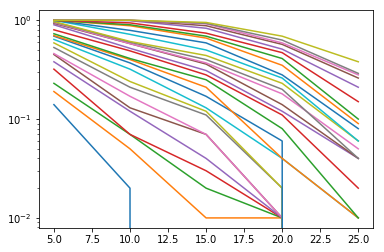

In [6]:
'''Generate the channel realizations'''

channel_coeff = np.ndarray((nrof_samples, nrof_subcarriers, nrof_snrs), dtype=np.complex128)

if channel_model != 'AWGN':
    for snr_index in range(nrof_snrs):
        channel_response = TDL_channel.channel_frequency_response( fft_size,
                                                                   relative_speed,
                                                                   channel_model,
                                                                   nrof_samples )

        channel_coeff[:,:,snr_index] = channel_response.T().to_numpy_ndarray()[:, :nrof_subcarriers]
else:
    channel_coeff[:, :, :] = 1

legend_strings = []

block_success_dataset = np.ndarray((nrof_samples, len( TRANSPORT_BLOCK_SIZES ), nrof_snrs))
channel_to_noise_ratio_dataset = np.ndarray((nrof_subcarriers, nrof_samples, nrof_snrs))

start = time.time()
for block_size_index in range( len( TRANSPORT_BLOCK_SIZES ) ):

    block_size = TRANSPORT_BLOCK_SIZES[ block_size_index]  + 24 # 24 bit CRC
    modorder = MODULATION_ORDERS[ block_size_index ]

    bler_vs_snr = []

    outcome = ray.get([_run_link_simulation.remote(block_size, 
                                                   modorder,
                                                   nrof_subcarriers,
                                                   snrs_db[i], 
                                                   channel_coeff[:,:,i]) for i in range(nrof_snrs)])

    for snr_index in range(nrof_snrs):
        block_success_dataset[:, block_size_index, snr_index] = outcome[snr_index][1]

        bler_vs_snr.append(outcome[snr_index][0])
        #print(outcome[snr_index][0])

    legend_strings.append('TBS %df' %(block_size))
    plt.semilogy(snrs_db, bler_vs_snr)

    print('Block size index %d, TBS %d, Elapsed: %0.2fs' %(block_size_index, 
                                                           block_size, 
                                                           time.time() - start))

FADING_CHANNEL_DATASET = {'channel': channel_coeff, 
                          'block_success': block_success_dataset,
                          'block_sizes': TRANSPORT_BLOCK_SIZES,
                          'snrs_db': snrs_db}

In [7]:
data_filepath = 'sim_data/sim_0001/'
data_filename = 'dataset.npy'  

if not os.path.exists(data_filepath):
    os.makedirs(data_filepath)  

np.save(data_filepath + data_filename, FADING_CHANNEL_DATASET)

#FADING_CHANNEL_DATASET

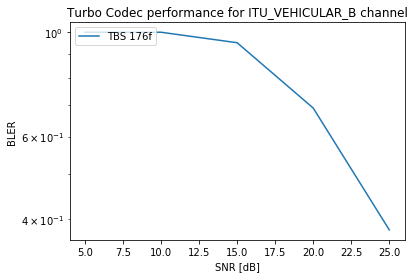

In [9]:
plt.xlabel('SNR [dB]')
plt.ylabel('BLER')
plt.legend(legend_strings, loc='upper left')
plt.title('Turbo Codec performance for %s channel' %(channel_model))
plt.savefig(data_filepath + 'plot.png')
plt.show()